### UPDATE: 30.03.2021

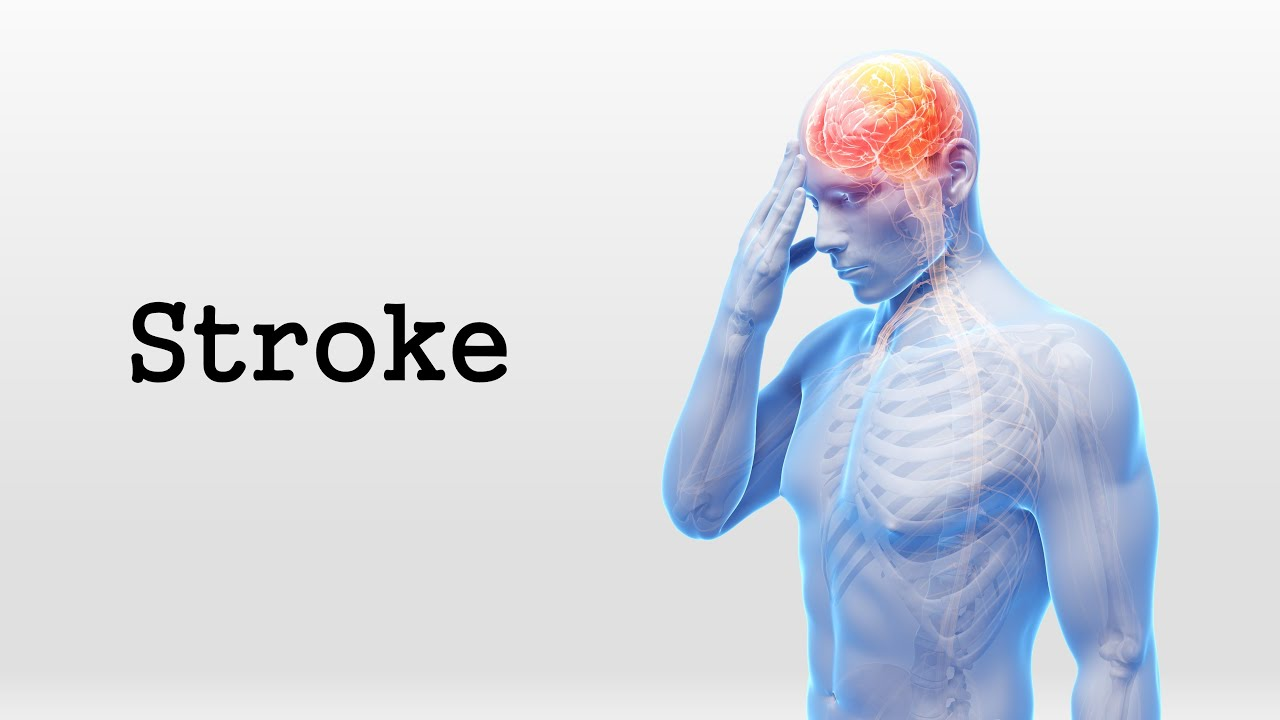

# Introduction
In this notebook you will see EDA, learn how to create new features and choose the best ones, how to prepare data for modeling, how to use Oversamplind and Undersampling Techniques, and see 100+ predicts.

### If you like my work then please upvote and write your opinion.

# Import Libs

In [ ]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import missingno as msno
import pandas_profiling as pdp

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

# models
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier, LassoCV
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier 
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

# feature selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel, SelectKBest, RFE, chi2

#model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# preprocessing
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve, ShuffleSplit
from sklearn.model_selection import cross_val_predict as cvp
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, confusion_matrix, explained_variance_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel, SelectKBest, RFE, chi2
#evaluation metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score  # for classification
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

import pandas_profiling as pp



# Data loading and overview

In [ ]:
df = pd.read_csv('../input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')
df.head()

In [ ]:
df.shape

In [ ]:
df = df.drop_duplicates()
df.shape

In [ ]:
df.info()

In [ ]:
df.dropna(inplace = True)

In [ ]:
for i in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    print(df[i].unique())

# EDA

In [ ]:
countplot_cols = ['heart_disease', 'hypertension', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [ ]:
boxplot_cols = ['age','avg_glucose_level', 'bmi']

In [ ]:
for i, column in enumerate(countplot_cols):
    sns.countplot(x=column, hue = 'stroke', data=df)
    plt.show()

In [ ]:
for i, column in enumerate(boxplot_cols):
    sns.boxplot(x='stroke', y=column, data=df)
    plt.show()

In [ ]:
#df = df.drop(df[df.smoking_status == 'Unknown'].index)
df = df.drop(df[df.gender == 'Other'].index)

In [ ]:
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
df['ever_married'] = le.fit_transform(df['ever_married'])
df['work_type'] = le.fit_transform(df['work_type'])
df['Residence_type'] = le.fit_transform(df['Residence_type'])
df['smoking_status'] = le.fit_transform(df['smoking_status'])
df = df.drop('id', axis = 1)
print('Encoding was successful ')

In [ ]:
#replace_values = {'Unknown': 'never smoked','formerly smoked': 'smokes'}

#df = df.replace({'smoking_status': replace_values})
#print('Replace was successfully')

In [ ]:
# Create new features

def feature_creation(df):
    df['age1'] = np.log(df['age'])
    df['age2'] = np.sqrt(df['age'])
    df['age3'] = df['age']**3
    df['bmi1'] = np.log(df['bmi'])
    df['bmi2'] = np.sqrt(df['bmi'])
    df['bmi3'] = df['bmi']**3
    df['avg_glucose_level1'] = np.log(df['avg_glucose_level'])
    df['avg_glucose_level2'] = np.sqrt(df['avg_glucose_level'])
    df['avg_glucose_level3'] = df['avg_glucose_level']**3
    for i in ['gender', 'age1', 'age2', 'age3', 'hypertension', 'heart_disease', 'ever_married', 'work_type']:
        for j in ['Residence_type', 'avg_glucose_level1','avg_glucose_level2', 'avg_glucose_level3', 'bmi1', 'bmi2', 'bmi3','smoking_status']:
            df[i+'_'+j] = df[i].astype('str')+'_'+df[j].astype('str')
    return df

df = feature_creation(df)

In [ ]:
df.shape

In [ ]:
# Determination categorical features

categorical_columns = []
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
features = df.columns.values.tolist()
for col in features:
    if df[col].dtype in numerics: continue
    categorical_columns.append(col)

categorical_columns

In [ ]:
# Encoding categorical features

for col in categorical_columns:
    if col in df.columns:
        #le = LabelEncoder()
        le.fit(list(df[col].astype(str).values))
        df[col] = le.transform(list(df[col].astype(str).values))
print('Encoding was successfull')

In [ ]:
# the number of features that we need to choose as a result
#num_features_opt = 25 
num_features_opt = 40 


# the somewhat excessive number of features, which we will choose at each stage
num_features_max = 50   

features_best = []

In [ ]:
X_train = df.drop('stroke', axis = 1).copy()
y_train = df.stroke.copy()

## Feature Selection with Pearson correlation

In [ ]:
# Threshold for removing correlated variables
threshold = 0.9

def highlight(value):
    if value > threshold:
        style = 'background-color: pink'
    else:
        style = 'background-color: green'
    return style

# Absolute value correlation matrix
corr_matrix = df.corr().abs().round(2)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.style.format("{:.2f}").applymap(highlight)

In [ ]:
# Select columns with correlations above threshold
collinear_features = [column for column in upper.columns if any(upper[column] > threshold)]

# Drop features with correlation above the threshold
features_filtered = df.drop(columns = collinear_features)
print('The number of features that passed the collinearity threshold: ', features_filtered.shape[1])

# Add filtered features
features_best.append(features_filtered.columns.tolist())

## Feature selection by the SelectFromModel with LinearSVC

In [ ]:
lsvc = LinearSVC(C=0.1, penalty="l1", dual=False).fit(X_train, y_train)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_train)
X_selected_df = pd.DataFrame(X_new, columns=[X_train.columns[i] for i in range(len(X_train.columns)) if model.get_support()[i]])

# add features
features_best.append(X_selected_df.columns.tolist())

## Feature selection with Lasso

In [ ]:
lasso = LassoCV(cv=3).fit(X_train, y_train)
model = SelectFromModel(lasso, prefit=True)
X_new = model.transform(X_train)
X_selected_df = pd.DataFrame(X_new, columns=[X_train.columns[i] for i in range(len(X_train.columns)) if model.get_support()[i]])

# add features
features_best.append(X_selected_df.columns.tolist())

## Feature selection by the SelectKBest with Chi-2

In [ ]:
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(abs(X_train), y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns

# add features
features_best.append(featureScores.nlargest(num_features_max,'Score')['Feature'].tolist())
print(featureScores.nlargest(len(dfcolumns),'Score')) 

## Feature selection by the RFE with Logistic Regression

In [ ]:
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_features_max, step=10, verbose=5)
rfe_selector.fit(X_train, y_train)
rfe_support = rfe_selector.get_support()
rfe_feature = X_train.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

In [ ]:
# add features
features_best.append(rfe_feature)

## Feature selection by the RFE with Random Forest

In [ ]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=200), threshold='1.25*median')
embeded_rf_selector.fit(X_train, y_train)

In [ ]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_train.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

In [ ]:
# add features
features_best.append(embeded_rf_feature)

## Feature selection by the VarianceThreshhold

In [ ]:
# Check whether all features have a sufficiently different meaning
selector = VarianceThreshold(threshold=10)
np.shape(selector.fit_transform(df))
features_best.append(list(np.array(df.columns)[selector.get_support(indices=False)]))

## Selection the best features

In [ ]:
# Show best features
features_best

In [ ]:
# The element is in at least one list of optimal features
main_cols_max = features_best[0]
for i in range(len(features_best)-1):
    main_cols_max = list(set(main_cols_max) | set(features_best[i+1]))
print(main_cols_max)

print('Cols:', len(main_cols_max))

In [ ]:
# Most common items in all lists of optimal features
main_cols = []
main_cols_opt = {feature_name : 0 for feature_name in df.columns.tolist()}
for i in range(len(features_best)):
    for feature_name in features_best[i]:
        main_cols_opt[feature_name] += 1
df_main_cols_opt = pd.DataFrame.from_dict(main_cols_opt, orient='index', columns=['Num'])
df_main_cols_opt.sort_values(by=['Num'], ascending=False).head(num_features_opt)

In [ ]:
# Select only our best features that are included in num_features_opt
main_cols = df_main_cols_opt.nlargest(num_features_opt, 'Num').index.tolist()
if not 'stroke' in main_cols:
    main_cols.append('stroke')
print(main_cols)

print("Quantity:", len(main_cols))

# Preparing to modeling

In [ ]:
# show best features

df[main_cols].head()

In [ ]:
X = df[main_cols].drop('stroke', axis = 1)
y = df[main_cols].stroke

In [ ]:
#scaling
rs = RobustScaler()

X_rs = pd.DataFrame(rs.fit_transform(X), columns = X.columns)

In [ ]:
#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_rs, y, test_size=0.2, random_state=42)

# Imbalance Technique

In [ ]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)
print(y_train_sm.value_counts())

In [ ]:
from imblearn.over_sampling import ADASYN
ada = ADASYN()
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)
print(y_train_ada.value_counts())

In [ ]:
from imblearn.combine import SMOTETomek
smtom = SMOTETomek()
X_train_smtom, y_train_smtom = smtom.fit_resample(X_train, y_train)
print(y_train_smtom.value_counts())

In [ ]:
from imblearn.combine import SMOTEENN
smenn = SMOTEENN()
X_train_smenn, y_train_smenn = smenn.fit_resample(X_train, y_train)
print(y_train_smenn.value_counts())

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state = 42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
print(y_train_rus.value_counts())

In [ ]:
from imblearn.under_sampling import NearMiss
NMv1 = NearMiss(version = 1)
X_train_NMv1, y_train_NMv1 = NMv1.fit_resample(X_train, y_train)
print(y_train_NMv1.value_counts())

In [ ]:
NMv2 = NearMiss(version = 2)
X_train_NMv2, y_train_NMv2 = NMv2.fit_resample(X_train, y_train)
print(y_train_NMv2.value_counts())

In [ ]:
NMv3 = NearMiss(version = 3)
X_train_NMv3, y_train_NMv3 = NMv3.fit_resample(X_train, y_train)
print(y_train_NMv3.value_counts())

In [ ]:
from imblearn.under_sampling import CondensedNearestNeighbour
CNN = CondensedNearestNeighbour()
X_train_CNN, y_train_CNN = CNN.fit_resample(X_train, y_train)
print(y_train_CNN.value_counts())

In [ ]:
from imblearn.under_sampling import OneSidedSelection
OSS = OneSidedSelection()
X_train_OSS, y_train_OSS = OSS.fit_resample(X_train, y_train)
print(y_train_OSS.value_counts())

In [ ]:
from imblearn.under_sampling import NeighbourhoodCleaningRule
NCR = NeighbourhoodCleaningRule()
X_train_NCR, y_train_NCR = NCR.fit_resample(X_train, y_train)
print(y_train_NCR.value_counts())

In [ ]:
from imblearn.under_sampling import EditedNearestNeighbours
ENN = EditedNearestNeighbours()
X_train_ENN, y_train_ENN = ENN.fit_resample(X_train, y_train)
print(y_train_ENN.value_counts())

In [ ]:
from imblearn.under_sampling import InstanceHardnessThreshold
IHT = InstanceHardnessThreshold()
X_train_IHT, y_train_IHT = IHT.fit_resample(X_train, y_train)
print(y_train_IHT.value_counts())

In [ ]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
RENN = RepeatedEditedNearestNeighbours()
X_train_RENN, y_train_RENN = RENN.fit_resample(X_train, y_train)
print(y_train_RENN.value_counts())


In [ ]:
from imblearn.under_sampling import AllKNN
ALLKNN = AllKNN()
X_train_ALLKNN, y_train_ALLKNN = ALLKNN.fit_resample(X_train, y_train)
print(y_train_ALLKNN.value_counts())


# Modeling

In [ ]:
def evaluate_model(clf, X_train,X_test, y_train, y_test, model_name, sample_type):
    print('--------------------------------------------')
    print('Model ', model_name)
    print('Data Type ', sample_type)
    y_pred = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    #accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred)
    #f1_train = f1_score(y_train, y_pred_train, average = 'binary')
    #recall_train = recall_score(y_train, y_pred_train, average = 'binary')
    #precision_train = precision_score(y_train, y_pred_train,  average = 'binary')
    f1_test = f1_score(y_test, y_pred, average='binary')
    recall_test = recall_score(y_test, y_pred, average='binary')
    precision_test = precision_score(y_test, y_pred, average='binary')
    print('TRAIN:', classification_report(y_train, y_pred_train))
    #print('TRAIN Accuracy:', accuracy_score(y_train, y_pred_train))
    #print("TRAIN: F1 Score ", f1_train)
    #print("TRAIN: Recall ", recall_train)
    #print("TRAIN: Precision ", precision_train)
    print('==================================================================')
    print('TEST:', classification_report(y_test, y_pred))
    #print('TEST Accuracy:', accuracy_score(y_test, y_pred))
    #print("TEST: F1 Score ", f1_test)
    #print("TEST: Recall ", recall_test)
    #print("TEST: Precision ", precision_test)
    return [model_name, sample_type, 
            f1_test,
            precision_test,
            recall_test, 
            accuracy_test]

In [ ]:
#17 models

models = {
    'Decision Trees': DecisionTreeClassifier(random_state=42),
    'Random Forest':RandomForestClassifier(random_state=42),
    'Linear SVC':LinearSVC(random_state=42),
    'AdaBoost Classifier':AdaBoostClassifier(random_state=42),
    'Stochastic Gradient Descent':SGDClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Support Vector Machines': SVC(random_state=42),
    'MLP Classifier': MLPClassifier(random_state=42),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=42),
    'Ridge Classifier': RidgeClassifier(),
    'Bagging Classifier': BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5),
    'Extra Trees Classifier': ExtraTreesClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'Gaussian Process Classification': GaussianProcessClassifier(random_state=42)
}

In [ ]:
#15 techniques

sampled_data = {
    'ACTUAL':[X_train, y_train],
    'SMOTE':[X_train_sm, y_train_sm],
    'ADASYN':[X_train_ada, y_train_ada],
    'SMOTE_TOMEK':[X_train_smtom, y_train_smtom],
    'SMOTE_ENN':[X_train_smenn, y_train_smenn],
    'Random Under Sampling': [X_train_rus, y_train_rus],
    'Near Miss1': [X_train_NMv1, y_train_NMv1],
    'Near Miss2': [X_train_NMv2, y_train_NMv2],
    'Near Miss3': [X_train_NMv3, y_train_NMv3],
    'Condensed Nearest Neighbour': [X_train_CNN, y_train_CNN],
    'One Sided Selection': [X_train_OSS, y_train_OSS],
    'Neighbourhood Cleaning Rule' : [X_train_NCR, y_train_NCR],
    'Edited Nearest Neighbours': [X_train_ENN, y_train_ENN],
    'Instance Hardness Threshold': [X_train_IHT, y_train_IHT],
    'Repeated Edited Nearest Neighbours': [X_train_RENN, y_train_RENN],
    'AllKNN': [X_train_ALLKNN, y_train_ALLKNN]
   
}

In [ ]:
%%time

output = []
for model_k, model_clf in models.items():
    for data_type, data in sampled_data.items():
        model_clf.fit(data[0], data[1])
        output.append(evaluate_model(model_clf, X_train, X_test, y_train, y_test, model_k, data_type))


# Result

In [ ]:
result = pd.DataFrame(output, columns=['Model', 'DataType',
                                       'F1',
                                       'Precision',
                                       'Recall', 
                                       'Accuracy'])
pd.set_option('display.max_rows', None)

result = result[result['F1']!=0]
result.sort_values(by="F1", ascending=False)

In [ ]:
result.shape

# We have 248 predicts :) 

### Top 5 F1 score

In [ ]:
result.sort_values(by = 'F1', ascending=False).head(5)

### Top 5 Precision score

In [ ]:
result.sort_values(by = 'Precision', ascending=False).head(5)

### Top 5 Recall score

In [ ]:
result.sort_values(by = 'Recall', ascending=False).head(5)

# Conclusion

**We looked at the imbalance techniques and predictions of 17 models.**

**We have a very good Recall value, but a relatively low Precision value.**

**What to do next? I think we need to do Grid Search CV for all imbalance of techniques and models and improve the Precision metric.**



# Write your opinion. Thanks!